## Final Project Submission

Please fill out:
* Student name: David Bartholomew
* Student pace: self paced
* Instructor name: Jeff Herman
* Blog post URL: https://dbarth411.medium.com/detecting-pneumonia-in-x-ray-images-with-a-convolutional-neural-network-735f68f40564

# X-ray Image Classification of Pneumonia in Pediatric Patients

This project involves an iterative approach to building a convolutional neural network model to classify x-ray images of pediatric patients, identifying whether or not patients have pneumonia. Transfer learning was used, but rather than freezing the previously built model, the network was retrained to improve overall accuracy.

### The Data:
The data for this project was downloaded directly from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. The data contains 5,856 x-ray images with a mix of RGB and grayscale images.

### Resizing Images:
Images were resized to 75x75 for efficiency when running on a local machine. Additionally, the prebuilt network, InceptionResNetv2, requires that the minimum image size is 75x75.

### Train and Test Sets:
The original train, test, and validation sets were 5,216, 624, and 16 images. All images and labels were combined and then resplit in order to increase the size of the test set to more accurately evaluate model results as 16 images alone would not give a clear picture. The final training set was slightly reduced to 5,153 images, the validation set was used in the modeling process to gauge model accuracy with 632 total images, and the test set was used to further gauge how the model would handle unseen data with 71 total images.

In [1]:
#Import necessary libraries
import tensorflow
from tensorflow import image
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from keras.utils.vis_utils import plot_model
import numpy as np
import os
import seaborn as sns
import pandas as pd
import random
import itertools
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from keras import models, layers, optimizers, regularizers, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.layers import Conv2D, Flatten, MaxPooling2D, ZeroPadding2D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set random seed
from numpy.random import seed
set_seed = 123
tensorflow.random.set_seed(set_seed)
seed(set_seed)

In [3]:
# Directory path
train_data_dir = 'chest_xray/train/'
test_data_dir = 'chest_xray/test/'
val_data_dir = 'chest_xray/val/'

# Get all the data in the directory chest_xray/test (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(75, 75), batch_size=624)

# Get all the data in the directory chest_xray/train (5216 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(75, 75), batch_size=5216)

# Get all the data in the directory chest_xray/train (5216 images), and reshape them
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(75, 75), batch_size=16)

preview_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=1)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)
preview_images, preview_labels = next(preview_generator)

Found 624 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [4]:
#Preview labels
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [5]:
#Combine train and test images/labels
all_images = np.concatenate((train_images, test_images, val_images))
labels = np.concatenate((train_labels, test_labels, val_labels))

In [6]:
#Replit the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=.12, random_state=set_seed)

In [7]:
#Replit the data into train and test sets
X_test, test_img, y_test, test_lbls = train_test_split(X_test, y_test, test_size=.10, random_state=set_seed)

In [8]:
#Change pixel values for data augmentation
i = (X_train >= 0) & (X_train < 25)
altered = np.where(i, 0, X_train)

In [9]:
#Add noise to preview image
i = (preview_images >= 0) & (preview_images < 40)
prev1 = np.where(i, 0, preview_images)

Original


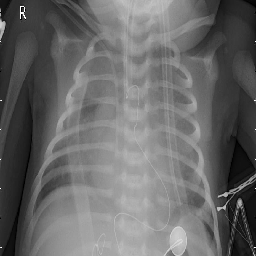

In [10]:
#Preview image
print("Original")
save_img('images/Original.png', array_to_img(preview_images[0]))
array_to_img(preview_images[0])

Altered Image


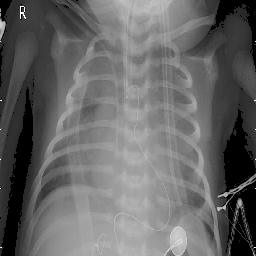

In [11]:
#Preview image
print("Altered Image")
save_img('images/Altered.png', array_to_img(prev1[0]))
array_to_img(prev1[0])

In [12]:
X_train = np.concatenate((X_train, altered))
y_train = np.concatenate((y_train, y_train))

In [13]:
#Print shapes of X_train, y_train, X_test, y_test
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

(10306, 75, 75, 3)
(10306, 2)
(632, 75, 75, 3)
(632, 2)


In [14]:
#Transpose y_train matrix for modeling
y_train = y_train.T[[1]]
y_train = y_train.T

In [15]:
#Transpose y_test matrix for modeling
y_test = y_test.T[[1]]
y_test = y_test.T

In [16]:
#Standardize the original data
X_train = X_train/255
X_test = X_test/255

In [17]:
#Preview shapes of data again before modeling
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10306, 75, 75, 3)
(10306, 1)
(632, 75, 75, 3)
(632, 1)


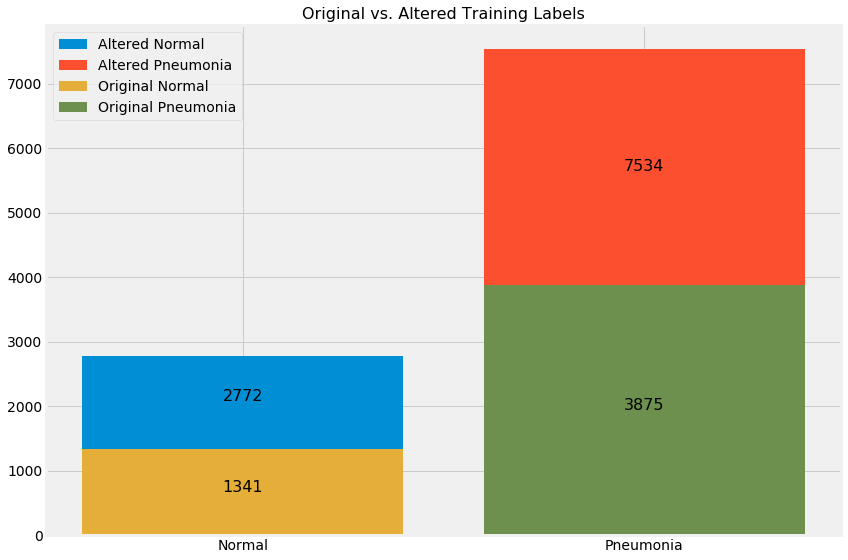

In [18]:
#Plot the original training data
plt.figure(figsize=(12, 8))
with plt.style.context('fivethirtyeight'):
    plt.bar(x=0, height=len(y_train) - np.sum(y_train), label='Altered Normal')
    plt.bar(x=1, height=np.sum(y_train), label='Altered Pneumonia')
    plt.text(x=0, y=(len(y_train) - np.sum(y_train))*.75, s=int(len(y_train) - np.sum(y_train)), fontsize=16, 
             color='black', horizontalalignment='center')
    plt.text(x=1, y=np.sum(y_train)*.75, s=int(np.sum(y_train)), fontsize=16, color='black', 
             horizontalalignment='center')
    plt.xticks([0, 1], labels=['Normal', 'Pneumonia'])
    plt.bar(x=0, height=train_labels[:,0].sum(), label='Original Normal')
    plt.bar(x=1, height=train_labels[:,1].sum(), label='Original Pneumonia')
    plt.title('Original vs. Altered Training Labels', fontsize=16)
    plt.text(x=0, y=train_labels[:,0].sum()/2, s=int(train_labels[:,0].sum()), fontsize=16, color='black', 
            horizontalalignment='center')
    plt.text(x=1, y=train_labels[:,1].sum()/2, s=int(train_labels[:,1].sum()), fontsize=16, color='black', 
            horizontalalignment='center')
    plt.legend()
    plt.tight_layout()
    plt.savefig('images/original_vs_alteredtraining.png')
    plt.show()

In [22]:
#Build Plot Confusion Matrix Function
def plot_confusion_matrix(cm, classes=[0, 1], normalize=False, title=None, cmap=plt.cm.Blues, ax=None):
    """
    Print and plot a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(np.arange(0, 1), [0, 1])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass

    thresh = cm.max() / 2.
    j_list = []
    for i in cm:
        for j in i:
            j_list.append(j)
    zero = j_list[:2]
    one = j_list[2:]
    for i, j in enumerate(zero):
        plt.text(x=i, y=0, s=j, horizontalalignment="center", fontsize=16, 
                 color="white" if j > thresh else "black")
        plt.text(x=0, y=0.2, s='True Negatives', horizontalalignment="center",
                 fontsize=16, 
                 color="white")
        plt.text(x=1, y=0.2, s='False Positives', horizontalalignment="center",
                 fontsize=16, 
                 color="white" if j > thresh else "black")
    for i, j in enumerate(one):
        plt.text(x=i, y=1, s=j, horizontalalignment="center", verticalalignment="center", fontsize=16, 
                 color="white" if j > thresh else "black")
        plt.text(x=0, y=1.2, s='False Negatives', horizontalalignment="center", 
                 fontsize=16, 
                 color="black")
        plt.text(x=1, y=1.2, s='True Positives', horizontalalignment="center", 
                 fontsize=16, 
                 color="white" if j > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')

In [23]:
layers_list = []

# Create Model Checkpoint 
mc = ModelCheckpoint('best_model_test.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

def build_model(optimizer, epochs, batch_size, callbacks=mc, weights={0:1,1:1}):
    """
    Build a neural network model, returning classification reports, confusion matrix, 
    and save best model using model checkpoint based on val_accuracy.
    
    Input Parameters: optimizer, epochs, batch_size, callbacks, weights
    """
    
    # Initialize a sequential model
    model = Sequential()

    # Add layers
    for i in layers_list:
        model.add(i)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    results = model.fit(X_train, y_train, callbacks=callbacks, class_weight=weights, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_test, y_test))
    build_model.results = results
    
    # Output (probability) predictions for the train and test set
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    build_model.y_hat_train = y_hat_train
    build_model.y_hat_test = y_hat_test
    
    #Visualize Results
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    print('-----------------------------------\n')
    
    # Print the loss and accuracy for the training set 
    results_train = model.evaluate(X_train, y_train)
    print('Train Results', results_train)
    print('-----------------------------------\n')
    
    # Print the loss and accuracy for the training set 
    results_test = model.evaluate(X_test, y_test)
    print('Test Results', results_test)
    print('-----------------------------------\n')
    
    # Print Classification Reports
    print('Train Classification Report')
    print(classification_report(y_train, np.round(y_hat_train, 0), 
                                target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
    print('-----------------------------------\n')
    
    print('Test Classification Report')
    print(classification_report(y_test, np.round(y_hat_test, 0), 
                                target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
    print('-----------------------------------\n')
    
    # load the saved model
    saved_model = load_model('best_model_test.h5')

    # evaluate the model
    _, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
    build_model.saved_model = saved_model
    print('Best Model Results\n')
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    print('-----------------------------------\n')
    
    #Create Confusion Matrices
    train_cm = confusion_matrix(y_true=y_train, y_pred=np.round(y_hat_train, 0))
    test_cm = confusion_matrix(y_true=y_test, y_pred=np.round(y_hat_test, 0))
    build_model.train_cm = train_cm
    build_model.test_cm = test_cm
    
    #Plot Train Confusion Matrices
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_confusion_matrix(cm=train_cm, 
                          cmap=plt.cm.Blues)
    
    plt.subplot(122)
    plot_confusion_matrix(cm=test_cm, 
                          cmap=plt.cm.Blues)
    plt.subplots_adjust(wspace=0.4)

Here we begin the modeling process, trying different parameters, adding layers, changing neurons, utilizing regularization techniques, and other changes to attempt to increase validation accuracy.

# Model 1

Epoch 1/50
103/104 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.7298
Epoch 00001: val_accuracy improved from -inf to 0.81171, saving model to best_model_test.h5
104/104 [==============================] - 27s 261ms/step - loss: 0.5590 - accuracy: 0.7298 - val_loss: 0.4787 - val_accuracy: 0.8117
Epoch 2/50
103/104 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8750
Epoch 00002: val_accuracy improved from 0.81171 to 0.93354, saving model to best_model_test.h5
104/104 [==============================] - 27s 260ms/step - loss: 0.2980 - accuracy: 0.8751 - val_loss: 0.1806 - val_accuracy: 0.9335
Epoch 3/50
103/104 [============================>.] - ETA: 0s - loss: 0.1727 - accuracy: 0.9355
Epoch 00003: val_accuracy improved from 0.93354 to 0.94146, saving model to best_model_test.h5
104/104 [==============================] - 27s 261ms/step - loss: 0.1726 - accuracy: 0.9356 - val_loss: 0.1439 - val_accuracy: 0.9415
Epoch 4/50
103/104 [========

Epoch 29/50
103/104 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9869
Epoch 00029: val_accuracy did not improve from 0.96044
104/104 [==============================] - 28s 272ms/step - loss: 0.0396 - accuracy: 0.9869 - val_loss: 0.1644 - val_accuracy: 0.9415
Epoch 30/50
103/104 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9870
Epoch 00030: val_accuracy improved from 0.96044 to 0.96203, saving model to best_model_test.h5
104/104 [==============================] - 29s 277ms/step - loss: 0.0351 - accuracy: 0.9870 - val_loss: 0.1226 - val_accuracy: 0.9620
Epoch 31/50
103/104 [============================>.] - ETA: 0s - loss: 0.0411 - accuracy: 0.9871
Epoch 00031: val_accuracy did not improve from 0.96203
104/104 [==============================] - 28s 265ms/step - loss: 0.0411 - accuracy: 0.9871 - val_loss: 0.1242 - val_accuracy: 0.9589
Epoch 32/50
103/104 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9865
Epoch

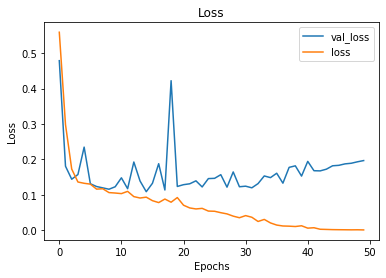

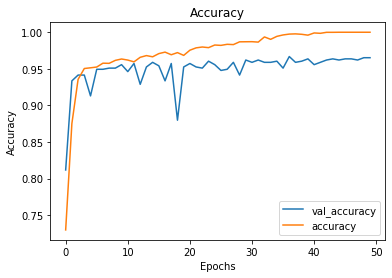

-----------------------------------

323/323 [==============================] - 8s 25ms/step - loss: 6.5230e-04 - accuracy: 1.0000
Train Results [0.0006523007177747786, 1.0]
-----------------------------------

20/20 [==============================] - 0s 23ms/step - loss: 0.1966 - accuracy: 0.9652
Test Results [0.1965772956609726, 0.9651898741722107]
-----------------------------------

Train Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      1.00      1.00      2772
Pneumonia (Class 1)       1.00      1.00      1.00      7534

           accuracy                           1.00     10306
          macro avg       1.00      1.00      1.00     10306
       weighted avg       1.00      1.00      1.00     10306

-----------------------------------

Test Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       0.93      0.94      0.94       180
Pneumonia (Class 1)       

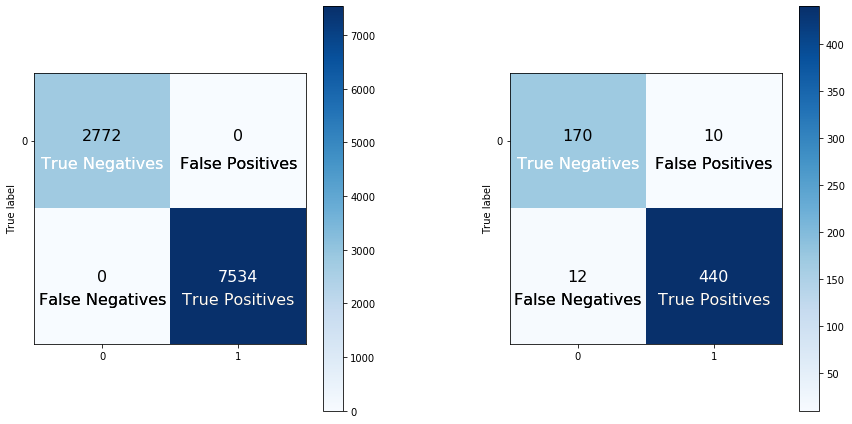

In [24]:
#Add layers
layers_list = []

layer1 = layers.Conv2D(75, (2, 2), padding='same', activation='relu', input_shape=(75, 75,  3))
layer2 = layers.MaxPooling2D((2, 2), padding='same')
layer3 = layers.Conv2D(75, (2, 2), padding='same', activation='relu')
layer4 = layers.MaxPooling2D((2, 2), padding='same')
layer5 = layers.Conv2D(75, (2, 2), padding='same', activation='relu')
layer6 = layers.MaxPooling2D((2, 2), padding='same')
layer7 = layers.Flatten()
layer8 = layers.Dense(75, activation='relu')
layer9 = layers.Dense(1, activation='sigmoid')

layers_list = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9]

#Utilize Stochastic Gradient Descent Optimizer
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=.9)

#Build model with pre-built function
build_model(optimizer=opt, epochs=50, batch_size=100, callbacks=mc)

# Model 2: Adding Batch Normalization and Dropout

Epoch 1/50
103/104 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.9170
Epoch 00001: val_accuracy did not improve from 0.96677
104/104 [==============================] - 41s 392ms/step - loss: 0.2081 - accuracy: 0.9170 - val_loss: 2.7433 - val_accuracy: 0.7152
Epoch 2/50
103/104 [============================>.] - ETA: 0s - loss: 0.1042 - accuracy: 0.9604
Epoch 00002: val_accuracy did not improve from 0.96677
104/104 [==============================] - 39s 377ms/step - loss: 0.1042 - accuracy: 0.9604 - val_loss: 3.6797 - val_accuracy: 0.7152
Epoch 3/50
103/104 [============================>.] - ETA: 0s - loss: 0.0892 - accuracy: 0.9671
Epoch 00003: val_accuracy did not improve from 0.96677
104/104 [==============================] - 40s 381ms/step - loss: 0.0892 - accuracy: 0.9671 - val_loss: 2.9994 - val_accuracy: 0.7152
Epoch 4/50
103/104 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9763
Epoch 00004: val_accuracy did not improve from 0.

Epoch 30/50
103/104 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.9851
Epoch 00030: val_accuracy did not improve from 0.96677
104/104 [==============================] - 38s 365ms/step - loss: 0.0441 - accuracy: 0.9852 - val_loss: 0.1843 - val_accuracy: 0.9494
Epoch 31/50
103/104 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979
Epoch 00031: val_accuracy did not improve from 0.96677
104/104 [==============================] - 38s 365ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.1663 - val_accuracy: 0.9620
Epoch 32/50
103/104 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.9986
Epoch 00032: val_accuracy did not improve from 0.96677
104/104 [==============================] - 38s 364ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.1963 - val_accuracy: 0.9494
Epoch 33/50
103/104 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.9989
Epoch 00033: val_accuracy did not improve fro

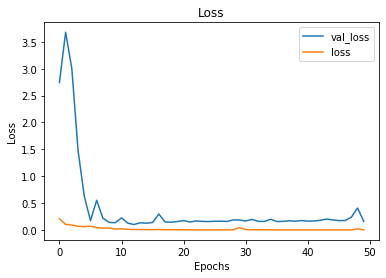

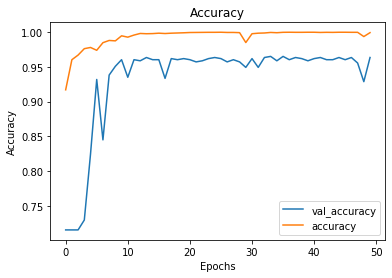

-----------------------------------

323/323 [==============================] - 9s 27ms/step - loss: 2.3889e-04 - accuracy: 1.0000
Train Results [0.00023889460135251284, 1.0]
-----------------------------------

20/20 [==============================] - 1s 26ms/step - loss: 0.1589 - accuracy: 0.9636
Test Results [0.15893672406673431, 0.9636076092720032]
-----------------------------------

Train Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      1.00      1.00      2772
Pneumonia (Class 1)       1.00      1.00      1.00      7534

           accuracy                           1.00     10306
          macro avg       1.00      1.00      1.00     10306
       weighted avg       1.00      1.00      1.00     10306

-----------------------------------

Test Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       0.95      0.92      0.93       180
Pneumonia (Class 1)     

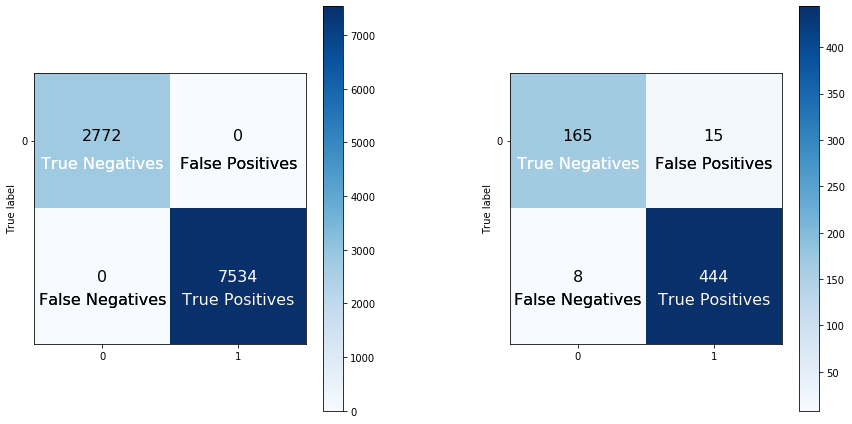

In [25]:
#Add layers
layers_list = []

layer1 = layers.Conv2D(75, (2, 2), padding='same', activation='relu', input_shape=(75, 75,  3))
layer2 = layers.MaxPooling2D((2, 2), padding='same')
layer3 = layers.BatchNormalization()
layer4 = layers.Dropout(.10)
layer5 = layers.Conv2D(75, (2, 2), padding='same', activation='relu')
layer6 = layers.MaxPooling2D((2, 2), padding='same')
layer7 = layers.BatchNormalization()
layer8 = layers.Dropout(.10)
layer9 = layers.Conv2D(75, (2, 2), padding='same', activation='relu')
layer10 = layers.MaxPooling2D((2, 2), padding='same')
layer11 = layers.BatchNormalization()
layer12 = layers.Dropout(.10)
layer13 = layers.Flatten()
layer14 = layers.Dense(75, activation='relu')
layer15 = layers.Dense(1, activation='sigmoid')

layers_list = [layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, layer11, 
               layer12, layer13, layer14, layer15]

#Utilize Stochastic Gradient Descent Optimizer
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=.9)

#Build model with pre-built function
build_model(optimizer=opt, epochs=50, batch_size=100, callbacks=mc)

# Model 3: Transfer Learning with InceptionResNetV2

In [26]:
#Import InceptionResNetV2
from keras.applications import InceptionResNetV2

#Build the model base with required input shape 75x75x3
cnn_base = InceptionResNetV2(weights='imagenet', 
                 include_top=False, 
                 input_shape=(75, 75, 3))

#View base structure
cnn_base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


Epoch 1/50
104/104 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9511
Epoch 00001: val_accuracy did not improve from 0.96677
104/104 [==============================] - 172s 2s/step - loss: 0.1245 - accuracy: 0.9511 - val_loss: 0.2009 - val_accuracy: 0.9098
Epoch 2/50
104/104 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9863
Epoch 00002: val_accuracy did not improve from 0.96677
104/104 [==============================] - 171s 2s/step - loss: 0.0392 - accuracy: 0.9863 - val_loss: 0.1074 - val_accuracy: 0.9604
Epoch 3/50
104/104 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9873
Epoch 00003: val_accuracy did not improve from 0.96677
104/104 [==============================] - 170s 2s/step - loss: 0.0336 - accuracy: 0.9873 - val_loss: 0.2661 - val_accuracy: 0.9335
Epoch 4/50
104/104 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9969
Epoch 00004: val_accuracy improved from 0.96677 to 0.97

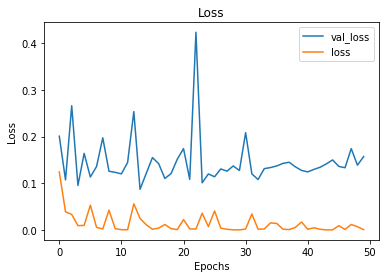

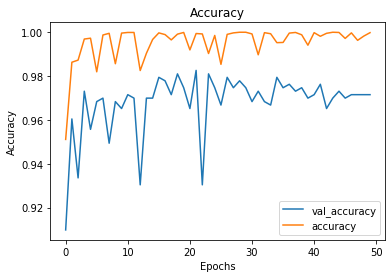

-----------------------------------

323/323 [==============================] - 28s 88ms/step - loss: 2.4835e-04 - accuracy: 1.0000
Train Results [0.0002483463613316417, 1.0]
-----------------------------------

20/20 [==============================] - 2s 86ms/step - loss: 0.1573 - accuracy: 0.9715
Test Results [0.15733875334262848, 0.9715189933776855]
-----------------------------------

Train Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      1.00      1.00      2772
Pneumonia (Class 1)       1.00      1.00      1.00      7534

           accuracy                           1.00     10306
          macro avg       1.00      1.00      1.00     10306
       weighted avg       1.00      1.00      1.00     10306

-----------------------------------

Test Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       0.98      0.92      0.95       180
Pneumonia (Class 1)     

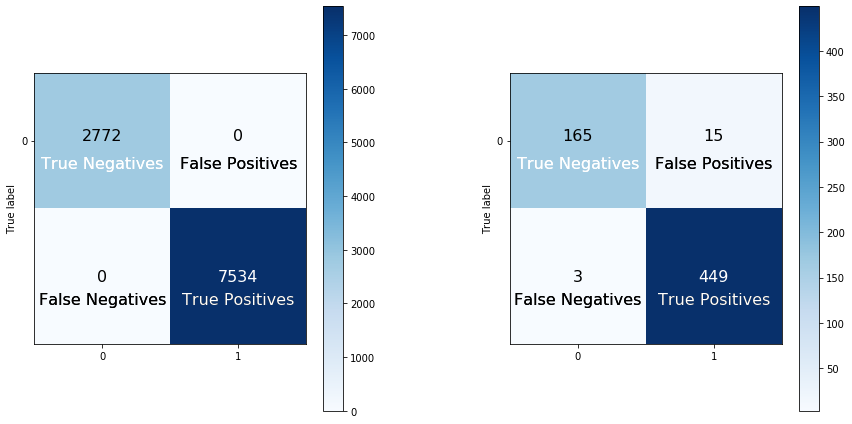

In [27]:
#Set random seed
np.random.seed(123)

#Add layers including InceptionResNetV2 base
layers_list = []

layer1 = cnn_base
layer2 = layers.Flatten()
layer3 = layers.Dense(75, activation='relu')
layer4 = layers.Dense(1, activation='sigmoid')

layers_list = [layer1, layer2, layer3, layer4]

#Utilize Stochastic Gradient Descent Optimizer
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=.9)

#Build model with pre-built function
build_model(optimizer=opt, epochs=50, batch_size=100, callbacks=mc)

# Final Train and Validation Confusion Matrices

Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.97      0.97       180
Pneumonia (Class 1)       0.99      0.99      0.99       452

           accuracy                           0.98       632
          macro avg       0.98      0.98      0.98       632
       weighted avg       0.98      0.98      0.98       632

-----------------------------------



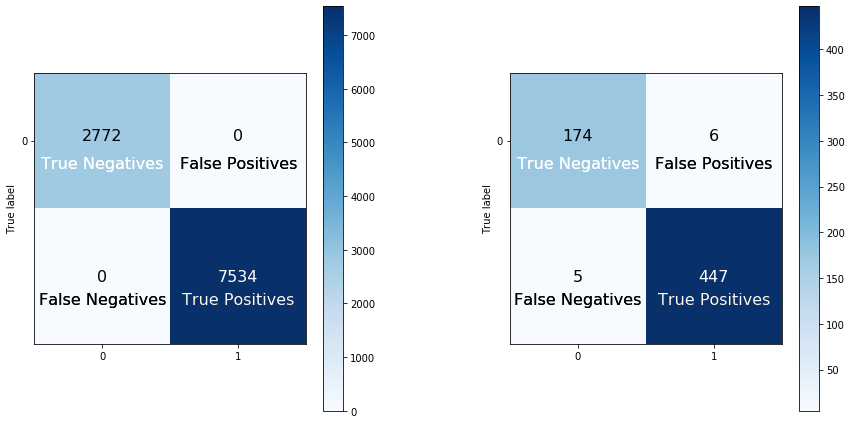

In [28]:
#Use the saved model to create predictions
y_hat_train = build_model.saved_model.predict(X_train)
y_hat_test = build_model.saved_model.predict(X_test)

#Create Confusion Matrices
train_cm = confusion_matrix(y_true=y_train, y_pred=np.round(y_hat_train, 0))
test_cm = confusion_matrix(y_true=y_test, y_pred=np.round(y_hat_test, 0))

print('Classification Report')
print(classification_report(y_test, np.round(y_hat_test, 0), 
                            target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print('-----------------------------------\n')

#Plot Train Confusion Matrix
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_confusion_matrix(cm=train_cm, 
                      cmap=plt.cm.Blues)

#Plot Test Confusion Matrix
plt.subplot(122)
plot_confusion_matrix(cm=test_cm, 
                      cmap=plt.cm.Blues)
plt.subplots_adjust(wspace=0.4)

The final accuracy is 98.3% for the validation set with 5 false negatives and 6 false positives. Now on to testing the final model with our unseen test set.

# Testing the Final Model

The below function is built to make predictions on our unseen test set of images.

In [43]:
#Build a function to make predictions on unseen data
def predict_new_images(test_img, test_lbls):
    '''Predict saved model results on unseen test set, print classification report and plot confusion matrix.'''
    
    #Transpose val labels
    test_lbls = test_lbls.T[[1]]
    test_lbls = test_lbls.T
    
    #Standardize the data
    test_final = test_img/255
    
    predictions = build_model.saved_model.predict(test_final)
    predict_new_images.predictions = predictions
    test_cm = confusion_matrix(y_true=test_lbls, y_pred=np.round(predictions, 0))
    
    print('Classification Report')
    print(classification_report(test_lbls, np.round(predictions, 0), 
                                target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
    print('-----------------------------------\n')
    
    plt.figure(figsize=(10, 6))
    plot_confusion_matrix(cm=test_cm, 
                      cmap=plt.cm.Blues)
    plt.savefig('images/final_model_result.png')

Classification Report
                     precision    recall  f1-score   support

   Normal (Class 0)       1.00      1.00      1.00        17
Pneumonia (Class 1)       1.00      1.00      1.00        54

           accuracy                           1.00        71
          macro avg       1.00      1.00      1.00        71
       weighted avg       1.00      1.00      1.00        71

-----------------------------------



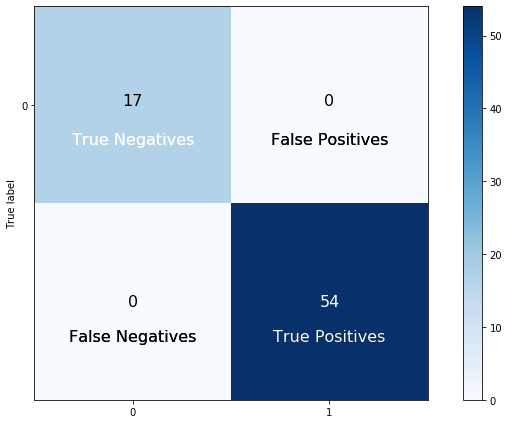

In [44]:
predict_new_images(test_img, test_lbls)

# Conclusion: 

The final model resulted in 100% accuracy on the unseen test set. Further research can include classifying whether pneumonia is bacterial or viral.